In [3]:
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler


bkg = np.zeros((150,400))
bkg[:] = np.nan

# load data

In [4]:
# load data
output_filepath = '/data/lipidatlas/REBUTTAL/WEBSITE/processed72_anatomical.h5ad'
adata = ad.read_h5ad(output_filepath)

# linking anatomical notation

In [5]:
# load the annatomical annotations
df_annotation = pd.read_excel('/data/lipidatlas/annotations/Supplementary_Table1.xlsx')

selected_lipids = []
annotations = []
for im, mz in enumerate(adata.var.values.flatten()):
    dist = np.abs(float(mz) - df_annotation.Estimated_mz)
    if np.min(dist) < 0.008: # this is maximum error in Da we consider
        ix = np.argmin(dist) 
        annotations.append(df_annotation.iloc[ix])
        selected_lipids.append(im)
annotations = pd.DataFrame(annotations)
annotations.head(2)

,Estimated_mz,Named_lipid,Lipid_sum_composition_amount,Adduct,Theoretical_mz_with_selected_adduct,Delta_mz,Formula,Neutral_mass,Lipid_specie_from_lcms,Lipids_species,...,Formula_metaspace_compound,Adduct_metaspace,Ion_metaspace,Theoretical_mz_metaspace,Fdr_metaspace,Sum_composition_metaspace_compound,Molecule_names_metaspace,Molecule_Id_metaspace,Database,Confirm_lipid_identity
199,478.329,LPC 16:0,LPC 16:0 (9817.829; 99.83%); LPE 19:0 (16.692;...,[M+H-H2O]+; [M+H-H2O]+,478.3286; 478.3286,0.0004,C24H50NO7P; C24H50NO7P,495.3325; 495.3325,LPC 16:0 (9817.829; 99.83%); LPE 19:0 (16.692;...,LPC 16:0; LPE 19:0,...,C24H48NO6P; C29H45NO3,M+H; M+Na,C24H48NO6P+H+; C29H45NO3+Na+,478.329,0.05,PE P-19:1,PE(P-19:1(12Z)/0:0); Ecalcidene,LMGP02070003; LMST03020681,SwissLipids,no
1,494.324,LPC 16:1,LPC 16:1 (185.451; 100.0%),[M+H]+,494.324,0.0001,C24H48NO7P,493.317,LPC 16:1 (185.451; 100.0%),LPC 16:1,...,C24H48NO7P; C29H45NO4,M+H; M+Na,C24H48NO7P+H+; C29H45NO4+Na+,494.324,0.2,PC 16:1; PE 19:1,"PC(16:1(9Z)/0:0), PC(16:1(9E)/0:0), PE(19:1(9Z...","LMGP01050022, LMGP01050021, LMGP02050019; LMFA...",SwissLipids,yes


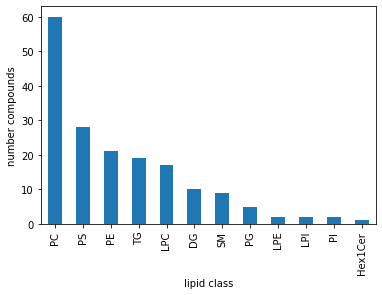

In [6]:
# show the distribution of lipid classes retrieved

annotations.Named_lipid.apply(lambda x: x.split(' ')[0]).value_counts().plot.bar()
plt.ylabel('number compounds')
plt.xlabel('lipid class')
plt.show()

# multivariate analysis

In [7]:
# remove pixels outside the tissue
masked_tissue = adata.X.sum(axis=1) > 1e-9

# minor filtering
num_pixels = []

for s in range(np.unique(adata.uns['x_coord']).shape[0]):
    mask_s = adata.uns['x_coord'][masked_tissue] == s
    n_pix = np.sum(adata.X[masked_tissue][mask_s] > 1e-4, axis=0) / np.sum(mask_s)
    num_pixels.append(n_pix)

num_pixels = np.array(num_pixels)

ix_keep = np.argwhere(np.min(num_pixels,axis=0) > 0.1).flatten() # lipids should be present in at least 10% of pixels in sections
ix_keep = np.intersect1d(ix_keep, selected_lipids) # keep only those that are annotated

In [8]:
# select pixels in the tissue, and annotated lipids
Y = adata.X[masked_tissue][:, ix_keep]
# z-standardize features
Ycnt = Y - Y.mean(0)
Ystd = Ycnt / Ycnt.std(0)
Ystd = np.nan_to_num(Ystd)

# prepare for NMF factorization
Ystd = MinMaxScaler().fit_transform(Ystd)

# fit model
model = NMF(n_components=15, init='random', random_state=0)
W = model.fit_transform(Ystd)

/home/halima/anaconda3/envs/lipidatlas_cloned/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


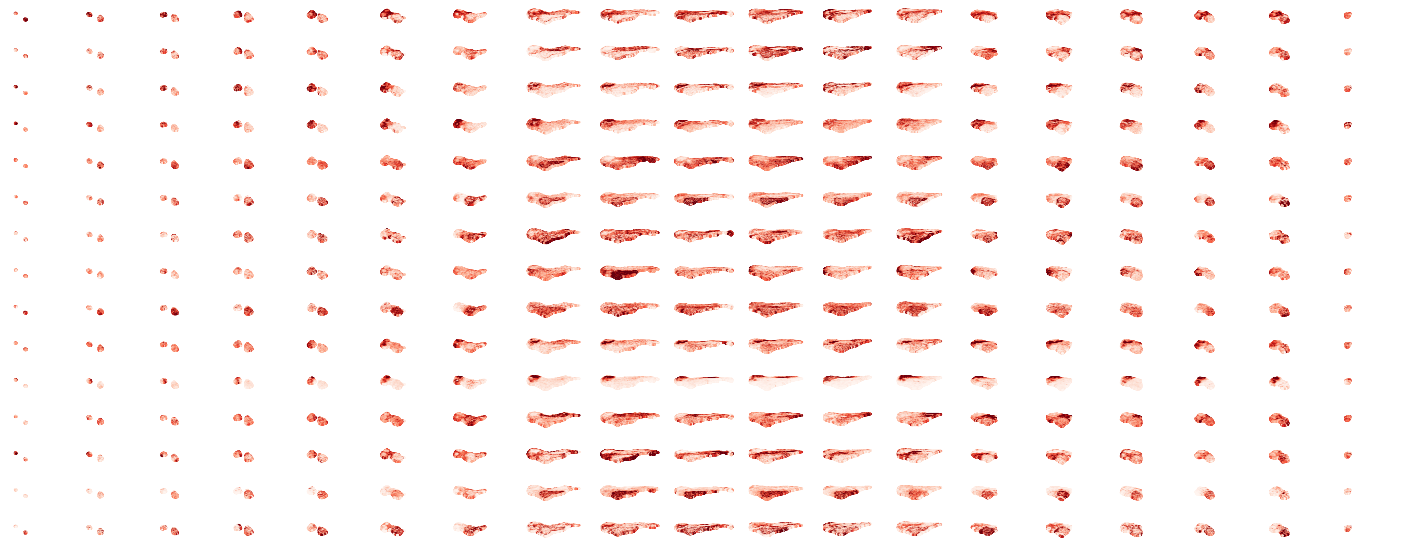

In [10]:
fig = plt.figure(None, (25,10))
gs = plt.GridSpec(15,19)


for i_w in np.arange(15):
    W_comp = W[:, i_w]
    vmin, vmax = np.percentile(W_comp, (2,95))
    for i_s, s in enumerate(np.unique(adata.uns['x_coord'][masked_tissue])):
        plt.subplot(gs[i_w, i_s])
        plt.imshow(bkg)
        indexes_sub = adata.uns['x_coord'][masked_tissue] == s
        plt.scatter(adata.uns['z_coord'][masked_tissue][indexes_sub],adata.uns['y_coord'][masked_tissue][indexes_sub],
                    c = W_comp[indexes_sub], s=1, rasterized=True, vmin=vmin, vmax=vmax, cmap='Reds')
        plt.axis('off')


# overlay annotations

In [13]:
def gridSection(adata, section=7):
    # select a specific section
    ix_section = adata.uns['x_coord'] ==section

    unique_values = np.unique(adata.uns['annotation'][ix_section])

    # Create 2D grid (x, y) for a single z-slice (if z=0)
    x = adata.uns['z_coord'][ix_section]
    y = adata.uns['y_coord'][ix_section]
    values = adata.uns['annotation'][ix_section]
    grid_x, grid_y = np.meshgrid(np.arange(x.min(), x.max() + 1), 
                                 np.arange(y.min(), y.max() + 1))

    # Interpolate the integer values on the 2D grid
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='nearest')
    
    return grid_x, grid_y, grid_values, unique_values, ix_section

# retrieve metadata for plotting
grid_x, grid_y, grid_values, unique_values, ix_section = gridSection(adata, 7)

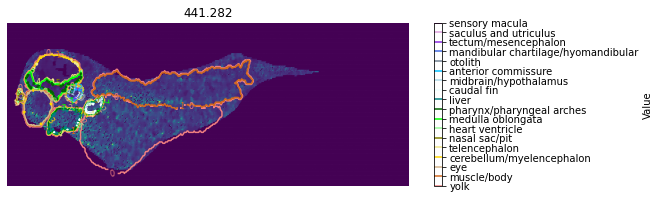

In [15]:
ix_mz = 35 # index of mz value to plot
fig = plt.figure(None, (9,3))
plt.title(adata.var.iloc[ix_mz].values[0])
plt.scatter(adata.uns['z_coord'][ix_section], adata.uns['y_coord'][ix_section],
            c=adata.X[ix_section,ix_mz], s=1)

contour = plt.contour(grid_x, grid_y, grid_values, levels=unique_values,
                      colors=adata.uns['df_annotation'].loc[unique_values].color.values)
plt.clabel(contour, inline=True, fontsize=8, fmt='%d')
cbar = plt.colorbar(label='Value')
cbar.set_ticks(unique_values)
cbar.set_ticklabels(adata.uns['df_annotation'].loc[unique_values].anatomicalName)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

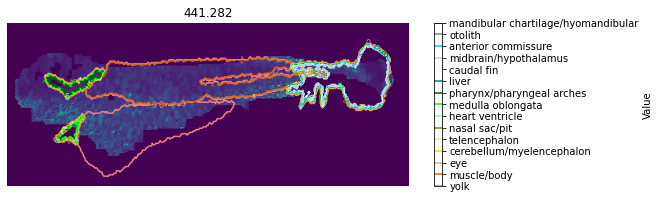

In [25]:
grid_x, grid_y, grid_values, unique_values, ix_section = gridSection(adata, 9)

ix_mz = 35 # index of mz value to plot
fig = plt.figure(None, (9,3))
plt.title(adata.var.iloc[ix_mz].values[0])
plt.scatter(adata.uns['z_coord'][ix_section], adata.uns['y_coord'][ix_section],
            c=adata.X[ix_section,ix_mz], s=1)

contour = plt.contour(grid_x, grid_y, grid_values, levels=unique_values,
                      colors=adata.uns['df_annotation'].loc[unique_values].color.values)
plt.clabel(contour, inline=True, fontsize=8, fmt='%d')
cbar = plt.colorbar(label='Value')
cbar.set_ticks(unique_values)
cbar.set_ticklabels(adata.uns['df_annotation'].loc[unique_values].anatomicalName)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()